<a href="https://colab.research.google.com/github/KabaTubare/deep_fake_defender_audioseal/blob/main/Deep_Fake_Defender_AI_Voice_Clone_Detection_HF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Install necessary libraries including AudioSeal
!pip install torchaudio soundfile matplotlib
!pip install audioseal


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.6/59.6 kB 10.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 17.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for julius: filename=julius-0.2.7-py3-none-any.whl size=21870 sha256=62cd04027b7846947ec60723107bb8d8555cedadc7cfd713ac9d65bad12c6e59
  Stored in directory: /root/.cache/pip/wheels/b9/b2/05/f883527ffcb7f2ead5438a2c23439aa0c881eaa9a4c80256f4
  Created wheel for antlr4-python3-runtime: filename=antlr4_python3_runtime-4.9.3-py3-none-any.whl size=144554 sha256=3fb1582f66d2819c6f37568d4b1fcf6c694d3494d764bdb974299a1f6e8e447e
  Stored in directory: /root/.cache/pip/wheels/12/93/dd/1f6a127edc45659556564c5730f6d4e300888f4bca2d4c5a88
Successfully built julius antlr4-python3-runtime


In [2]:
import torch
import torchaudio
import urllib.request
import matplotlib.pyplot as plt
from IPython.display import display, Audio, HTML
import torchaudio.transforms as T
from google.colab import files


In [3]:
# Upload files
uploaded = files.upload()

Saving human-voice-2-tw.mp3 to human-voice-2-tw.mp3


Uploaded file: human-voice-2-tw.mp3


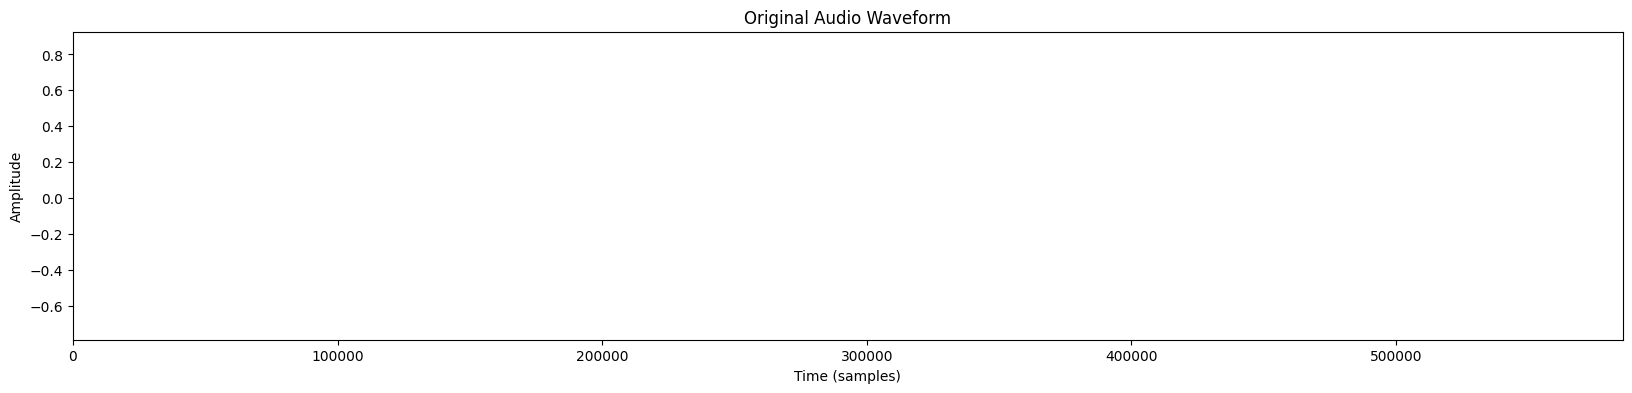

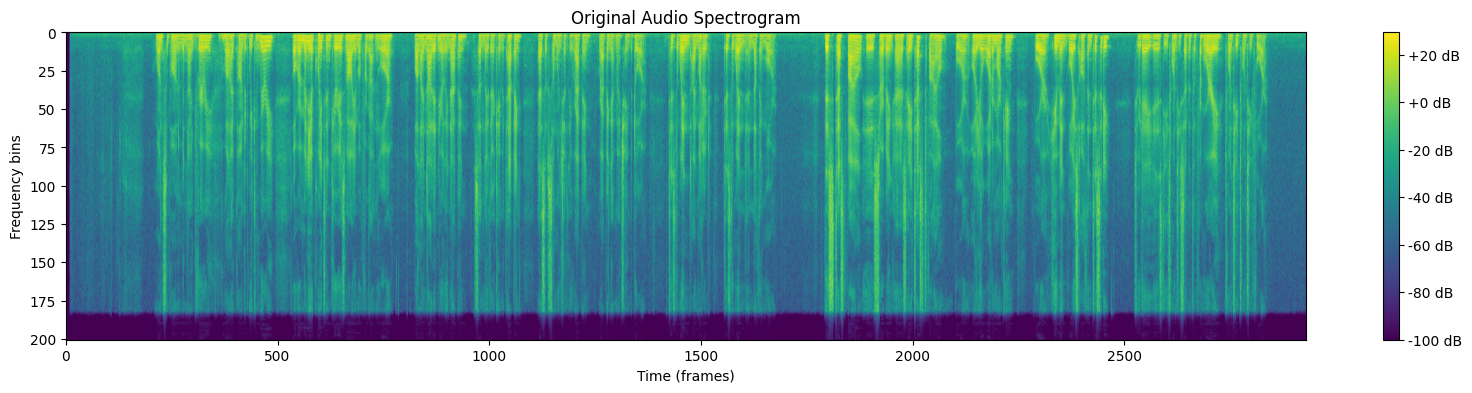

Downloading: "https://dl.fbaipublicfiles.com/audioseal/6edcf62f/generator.pth" to /root/.cache/audioseal/ed44c25c8ea96da64ffa2873
100%|██████████| 56.1M/56.1M [00:00<00:00, 255MB/s]


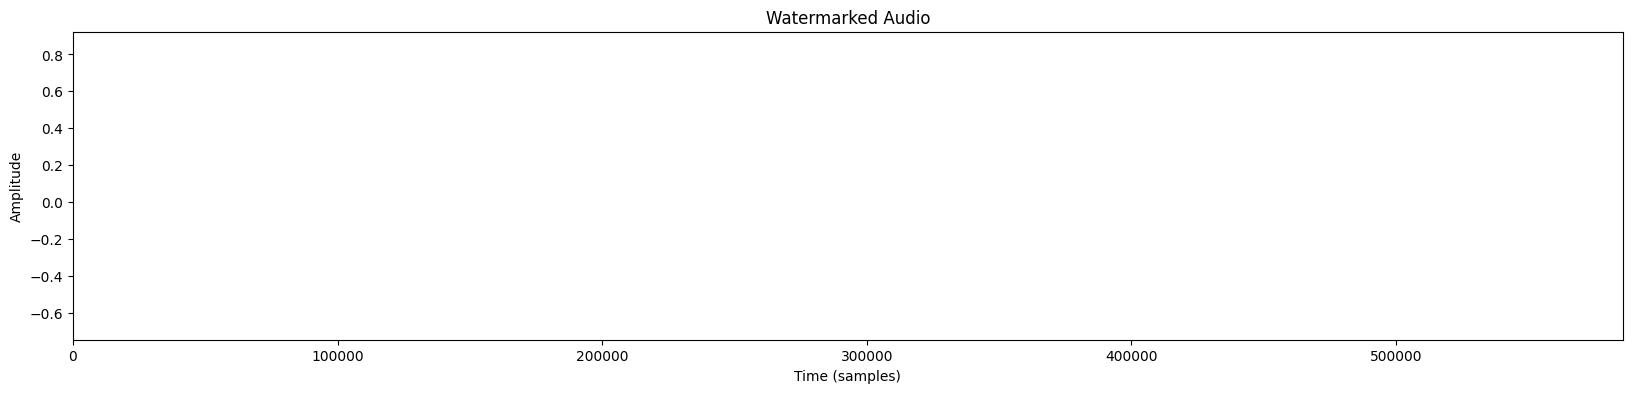

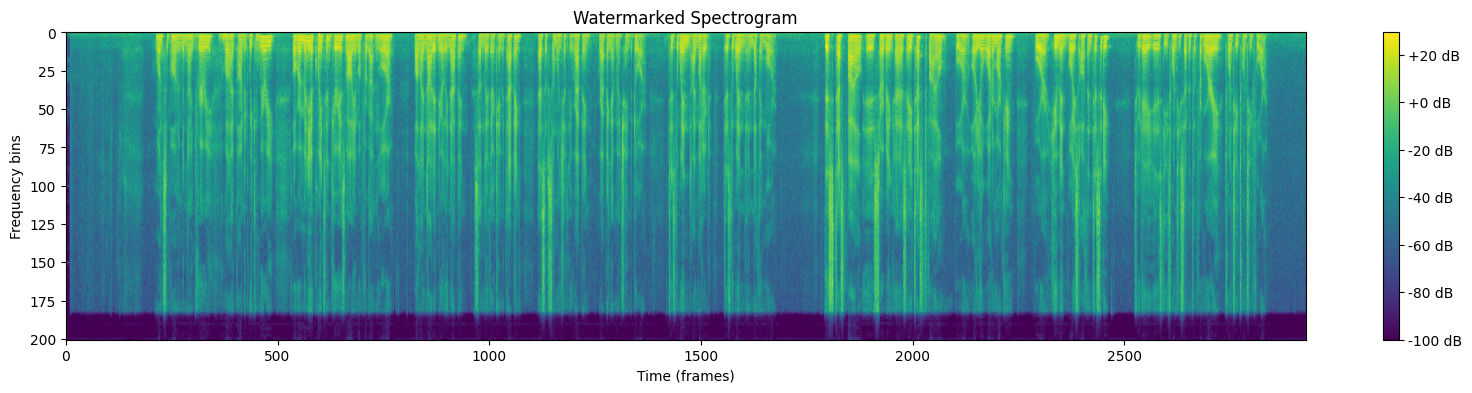

Downloading: "https://dl.fbaipublicfiles.com/audioseal/6edcf62f/detector.pth" to /root/.cache/audioseal/d377e551c354e9b70cb7ebd5
100%|██████████| 33.1M/33.1M [00:02<00:00, 12.8MB/s]



This is likely a watermarked audio: 0.9999436736106873
This is likely an unwatermarked audio: 0.0009969408856704831


In [ ]:
# Assuming you know the name of the file you uploaded or it's the only file
filename = next(iter(uploaded))
print(f"Uploaded file: {filename}")

# Adjust display settings for the notebook to use the full container width
display(HTML("<style>.container { width:100% !important; }</style>"))

# Set the default figure size for matplotlib plots
plt.rcParams["figure.figsize"] = (20, 3)

# Load the uploaded audio file
audio, sr = torchaudio.load(filename)

# Define the play_audio function
from IPython.display import Audio

def play_audio(waveform, sample_rate):
    display(Audio(waveform.numpy(), rate=sample_rate))

def plot_waveform(waveform, sample_rate, title="Waveform"):
    plt.figure(figsize=(20, 4))
    # Ensure waveform is 2D (channels, samples) and select the first channel if more than one
    if waveform.dim() == 3:
        waveform = waveform[0]  # Select first batch
    if waveform.size(0) > 1:  # More than one channel
        waveform = waveform[0]  # Select first channel
    # Detach waveform from the computational graph and convert to NumPy for plotting
    plt.plot(waveform.detach().numpy())
    plt.title(title)
    plt.ylabel('Amplitude')
    plt.xlabel('Time (samples)')
    plt.xlim([0, waveform.size(-1)])
    plt.show()


def plot_spectrogram(waveform, sample_rate, title="Spectrogram", n_fft=400):
    # Ensure waveform is 2D for the spectrogram transform
    if waveform.dim() == 3 and waveform.size(0) == 1:
        waveform = waveform.squeeze(0)  # Remove batch dimension if it's 1

    spectrogram_transform = T.Spectrogram(n_fft=n_fft, power=2)
    spectrogram = spectrogram_transform(waveform)

    # Convert to dB scale for visualization purposes
    spectrogram_db = torchaudio.transforms.AmplitudeToDB()(spectrogram)

    plt.figure(figsize=(20, 4))
    # Remove batch and channel dimensions for plotting, if present
    if spectrogram_db.dim() > 2:
        spectrogram_db = spectrogram_db.squeeze(0)
    plt.imshow(spectrogram_db.numpy(), cmap='viridis', aspect='auto')
    plt.title(title)
    plt.ylabel('Frequency bins')
    plt.xlabel('Time (frames)')
    plt.colorbar(format="%+2.0f dB")
    plt.show()

# Visualize the original audio
plot_waveform(audio, sr, "Original Audio Waveform")
plot_spectrogram(audio, sr, "Original Audio Spectrogram")
play_audio(audio, sr)


# Watermarking Process
from audioseal import AudioSeal

# Load the generator model
model = AudioSeal.load_generator("audioseal_wm_16bits")

# We add the batch dimension to the single audio to mimic the batch watermarking
audios = audio.unsqueeze(0)

# Generate watermark and apply it to the audio
watermark = model.get_watermark(audios)
watermarked_audio = audios + watermark

# Alternatively, you can also call forward() function directly with different tune-down / tune-up rate
watermarked_audio = model(audios, alpha=1)

# Ensure watermarked_audio is detached and prepared for visualization
watermarked_audio_detached = watermarked_audio.detach()

# Visualize the watermarked audio, making sure to detach and possibly remove the batch dimension
watermarked_audio_detached = watermarked_audio.detach()

# If there's a batch dimension, we should remove it before plotting
if watermarked_audio_detached.dim() == 3 and watermarked_audio_detached.shape[0] == 1:
    watermarked_audio_detached = watermarked_audio_detached.squeeze(0)

plot_waveform(watermarked_audio_detached, sr, "Watermarked Audio")
plot_spectrogram(watermarked_audio_detached, sr, "Watermarked Spectrogram")
play_audio(watermarked_audio_detached, sr)  # Remove .squeeze() if you want to play stereo


# Embedding a secret message
secret_message = torch.randint(0, 2, (1, 16), dtype=torch.int32)
watermarked_audio = model(audios, message=secret_message, alpha=1)

# Detecting Watermarks
detector = AudioSeal.load_detector("audioseal_detector_16bits")

result, message = detector.detect_watermark(watermarked_audio, message_threshold=0.5)
print(f"\nThis is likely a watermarked audio: {result}")

result2, message2 = detector.detect_watermark(audios, message_threshold=0.5)
print(f"This is likely an unwatermarked audio: {result2}")

# Robustness against attacks
from audioseal.attacks import AudioEffects as af

# Pink noise attack
pink_noised_audio = af.pink_noise(watermarked_audio, noise_std=0.2)
plot_waveform(pink_noised_audio, sr, title="Audio with Pink Noise - Waveform")
plot_spectrogram(pink_noised_audio, sr, title="Audio with Pink Noise - Spectrogram")
result, message = detector.detect_watermark(pink_noised_audio)
print(f"Pink noise attack result: {result}")

# Lowpass filter attack, corrected function call
lowpass_filtered = af.lowpass_filter(watermarked_audio, cutoff_freq=5000, sample_rate=sr)
plot_waveform(lowpass_filtered, sr, title="Lowpass Filtered Audio - Waveform")
plot_spectrogram(lowpass_filtered, sr, title="Lowpass Filtered Audio - Spectrogram")
result, message = detector.detect_watermark(lowpass_filtered)
print(f"Lowpass filter attack result: {result}")
